#Модифицируйте код для работы с другим датасетом и улучшите производительность модели.

Замените датасет tf_flowers(изображения цветов) из лекции (Использование_существующих_моделей_и_дообучение) на один из предложенных:


In [1]:
"cats_vs_dogs"           # Кошки vs собаки
"stanford_dogs"          # 120 пород собак
"caltech_birds2011"      # Птицы
"horses_or_humans"       # Лошади vs люди
"imagenet2012"           # Большой датасет (1000 классов)
"food101"                # Еда
"oxford_flowers102"      # Цветы
"plant_village"          # Болезни растений.

'plant_village'


Измените количество классов в последнем слое соответственно. Проведите обучение и оцените результаты.
Попробуйте другую архитектуру (например, ResNet50 вместо VGG16).Поэкспериментируйте с размером изображений.
Выведите 5 правильно распознанных объектов с подписями и 5 неправильно распознанных изображений с подписями. Сделайте выводы

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
MODEL_INPUT_SIZE = (224, 224)

## Подготовка данных

In [18]:
train_ds = tfds.load(
    "cats_vs_dogs",
    split="train[:60%]",
    as_supervised=True,
    shuffle_files=True
)

val_ds = tfds.load(
    "cats_vs_dogs",
    split="train[60%:80%]",
    as_supervised=True
)

test_ds = tfds.load(
    "cats_vs_dogs",
    split="train[80%:]",
    as_supervised=True
)

In [19]:
def preprocess_dataset(image, label):
    image = tf.image.resize(image, MODEL_INPUT_SIZE)
    image = preprocess_input(image)
    return image, label


train_ds = train_ds.map(preprocess_dataset).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_dataset).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_dataset).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=train_ds.element_spec[0].shape[1:])
base_model.trainable = False

In [21]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
flatten_layer = Flatten()
dense_layer_1 = Dense(50, activation='relu')
dense_layer_2 = Dense(20, activation='relu')
prediction_layer = Dense(2, activation='softmax')

model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │     5,017,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,606,424 (109.12 MB)

 Trainable params: 5,018,712 (19.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Дообучение модели

In [24]:
from keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(
    monitor='val_accuracy',  # отслеживаем точность на валидационной выборке
    mode='max',              # ищем максимальное значение (для accuracy). Для loss было бы mode='min'
    patience=5,              # если за 5 эпох подряд val_accuracy не улучшается, обучение останавливается
    restore_best_weights=True # после остановки восстанавливает веса модели с лучшей эпохи
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.9579 - loss: 0.7126 - val_accuracy: 0.9826 - val_loss: 0.2125
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 62s 141ms/step - accuracy: 0.9849 - loss: 0.1888 - val_accuracy: 0.9837 - val_loss: 0.2372
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.9934 - loss: 0.0509 - val_accuracy: 0.9865 - val_loss: 0.1764
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 55s 124ms/step - accuracy: 0.9963 - loss: 0.0220 - val_accuracy: 0.9890 - val_loss: 0.1895
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9871 - val_loss: 0.3142
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.9984 - loss: 0.0171 - val_accuracy: 0.9890 - val_loss: 0.2240
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 62s 141ms/step - accuracy: 0.9983 - loss: 0.0221 - val_accuracy: 0.9824 - val_loss: 0.3015
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.9950 - loss: 0

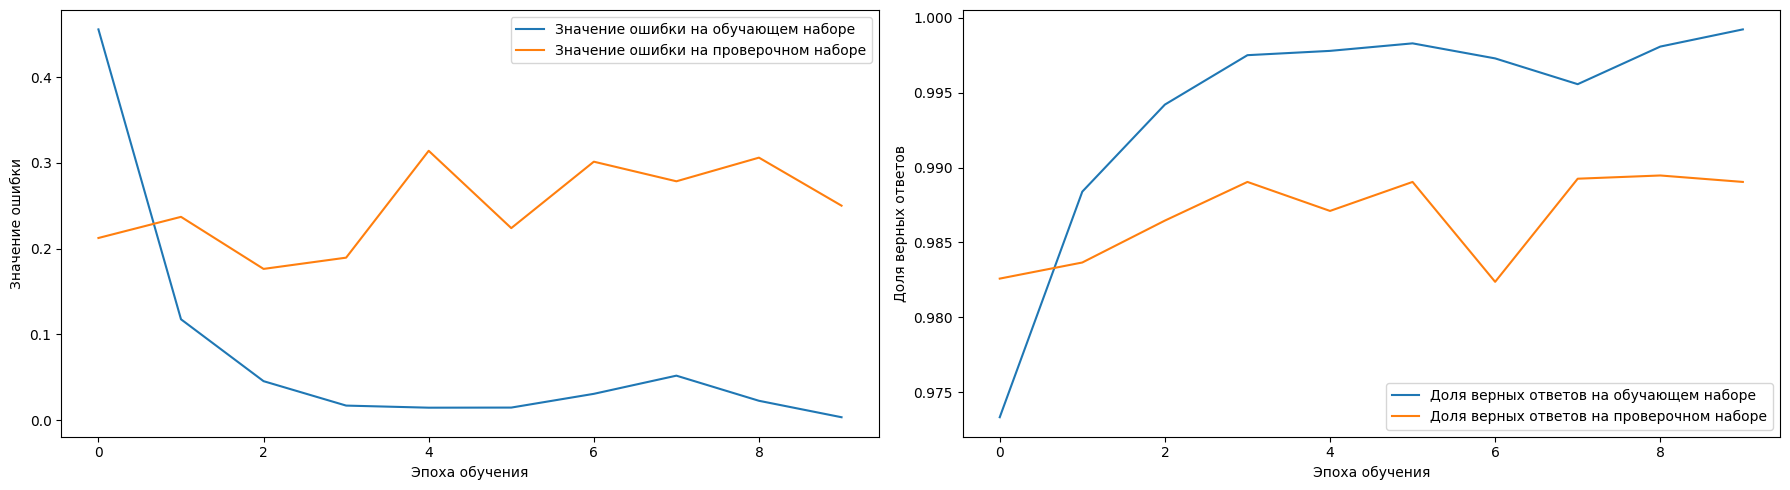

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
ax1.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Значение ошибки')
ax1.legend()

ax2.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
ax2.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Доля верных ответов')
ax2.legend()

plt.tight_layout()
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_ds)

146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9880 - loss: 0.2818


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем предсказания для тестовой выборки
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Собираем настоящие метки и изображения
true_labels = []
images = []
for batch_images, batch_labels in test_ds:
    true_labels.extend(batch_labels.numpy())
    images.extend(batch_images.numpy())

true_labels = np.array(true_labels)
images = np.array(images)

# Определяем правильные и неправильные предсказания
correct_predictions = predicted_classes == true_labels
incorrect_predictions = predicted_classes != true_labels

# Индексы правильных и неправильных предсказаний
correct_indices = np.where(correct_predictions)[0]
incorrect_indices = np.where(incorrect_predictions)[0]

print(f"Правильно предсказано: {len(correct_indices)}")
print(f"Неправильно предсказано: {len(incorrect_indices)}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step
Правильно предсказано: 4592
Неправильно предсказано: 60


In [33]:
def plot_predictions(images, true_labels, predicted_classes, indices, title):
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices[:5]):  # первые 5
        plt.subplot(2, 5, i + 1)
        image = images[idx]
        image = np.clip(image, 0, 255).astype(np.uint8)

        plt.imshow(image)
        true_label = "Собака" if true_labels[idx] == 1 else "Кошка"
        pred_label = "Собака" if predicted_classes[idx] == 1 else "Кошка"

        color = 'green' if true_labels[idx] == predicted_classes[idx] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

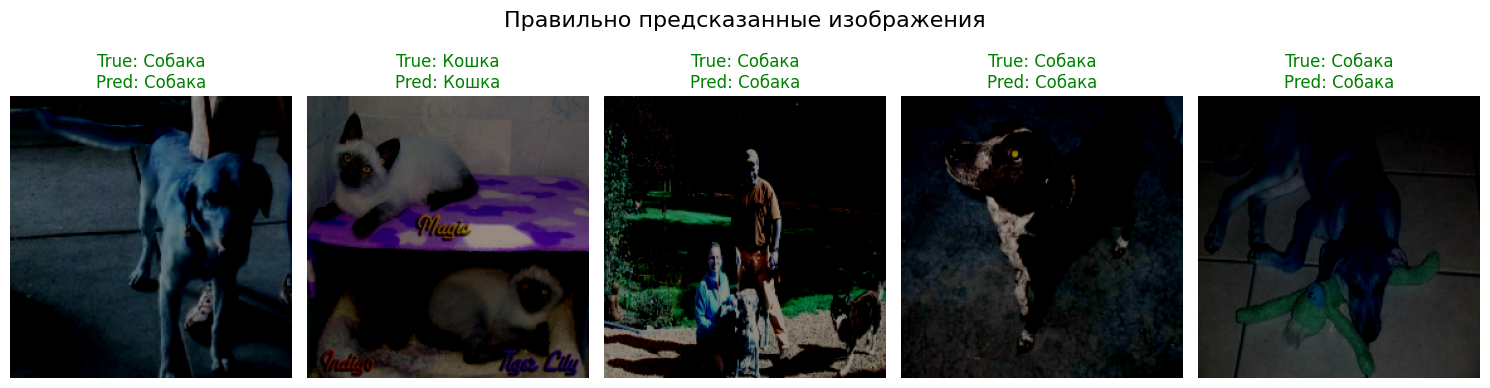

In [34]:
plot_predictions(images, true_labels, predicted_classes, correct_indices,
                    "Правильно предсказанные изображения")

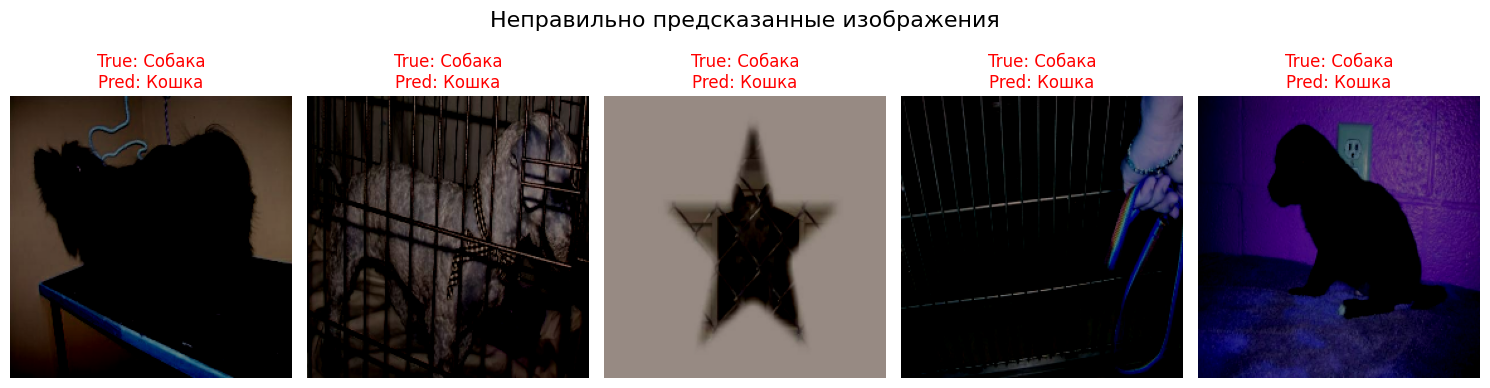

In [35]:
plot_predictions(images, true_labels, predicted_classes, incorrect_indices,
                    "Неправильно предсказанные изображения")